# Fairness Checking: Equalized Odds Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [1]:
!pip install pulp

In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [3]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [4]:
pred_df = pd.read_csv('./../predicted_data/logreg_COMPAS.csv')

In [5]:
pred_df.head(5)

,Unnamed: 0,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction,prediction_prob
0,6128,1,51,1,0,0,0,7,1,0,1,1,0,0.409895
1,4571,1,24,1,0,0,0,1,1,0,1,1,1,0.571310
2,1426,1,21,0,0,0,0,0,1,1,0,1,0,0.497028
3,3209,1,49,0,0,0,0,0,0,0,1,0,0,0.037173
4,5771,1,20,1,0,0,0,0,1,1,0,1,1,0.660504


In [6]:
len(pred_df)

1232

In [7]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [8]:
# Our true label Y is risk_recid, and y = 0 or y = 1. 
y = pred_df['risk_recid']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [9]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [10]:
# Sanity check
print(len(a_0))
print(len(a0_y1) + len(a0_y0))
print(len(a_1))
print(len(a1_y1) + len(a1_y0))

596
596
636
636


In [11]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(a_0_indices) + len(a_1_indices))
pi_0_1 = float(len(a0_y1))/(len(a_0_indices) + len(a_1_indices))
pi_1_0 = float(len(a1_y0))/(len(a_0_indices) + len(a_1_indices))
pi_1_1 = float(len(a1_y1))/(len(a_0_indices) + len(a_1_indices))

In [12]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)

0.33035714285714285
0.1534090909090909
0.21428571428571427
0.30194805194805197


In [13]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = pred_df['prediction_prob']
np.asarray(f_X)

array([0.40989479, 0.57131   , 0.49702751, ..., 0.83243155, 0.73909345,
       0.98560483])

In [14]:
# Check if the dimensions match
print(len(f_X))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

1232
1232


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [15]:
# Input: function f(X), constraint, y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, lower_bound, upper_bound, y_value):
  # Make sure constraint is within bounds
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint we set on the w's. Experiment with this
  for weight in w:
    model += w[weight] >= lower_bound
    model += w[weight] <= upper_bound
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Linear Program (Y = 0)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [16]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y0_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(1, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 0)
  y0_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

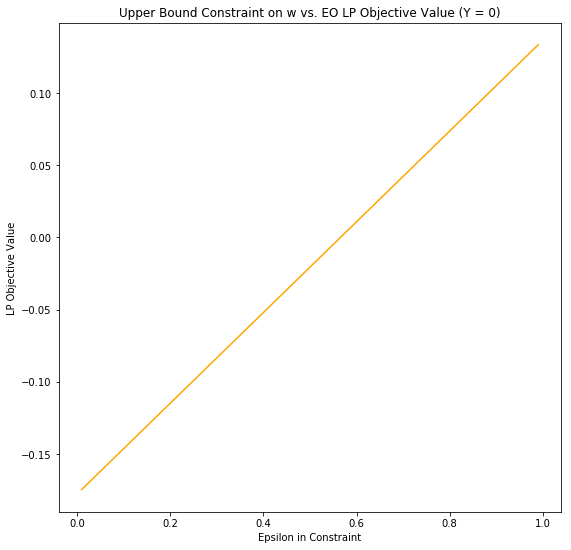

In [17]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y0_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

In [18]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

99
99


<BarContainer object of 1232 artists>

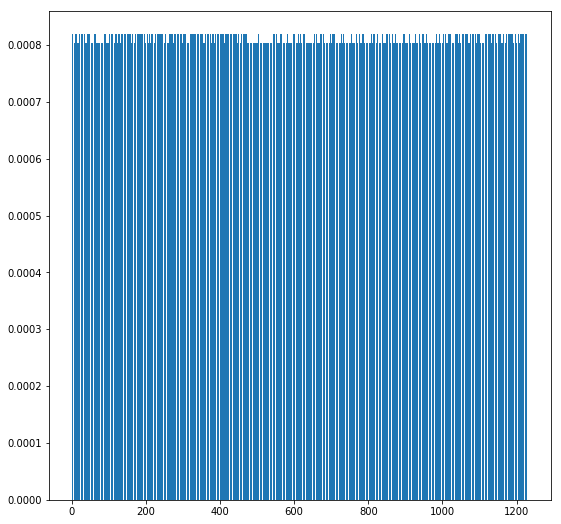

In [19]:
# Plot the distribution of weights
plt.figure(figsize=(9,9))
plt.bar(epsilon_to_weights[0.01].keys(), epsilon_to_weights[0.01].values())

In [20]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

1232
1232


## Marginal Distributions (Y = 0)

In [21]:
pred_df['weights'] = epsilon_to_weights[0.9].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction,prediction_prob,weights
0,6128,1,51,1,0,0,0,7,1,0,1,1,0,0.409895,0.001542
1,4571,1,24,1,0,0,0,1,1,0,1,1,1,0.571310,0.001542
2,1426,1,21,0,0,0,0,0,1,1,0,1,0,0.497028,0.001542
3,3209,1,49,0,0,0,0,0,0,0,1,0,0,0.037173,0.000081
4,5771,1,20,1,0,0,0,0,1,1,0,1,1,0.660504,0.001542


In [22]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [23]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{1: 0.823051948051948, 0: 0.17694805194805194}
{0: 0.17840909174800001, 1: 0.8215909129369922}


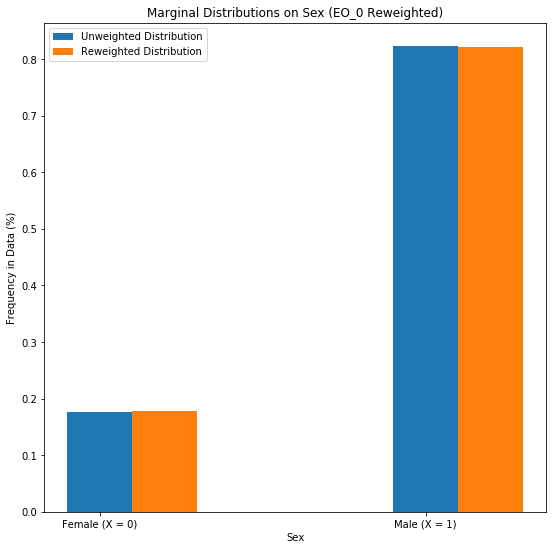

In [24]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_0 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [25]:
X_age_freq = freq_dict(pred_df, 'age')
X_age_marginal = marginalize(pred_df, 'age', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

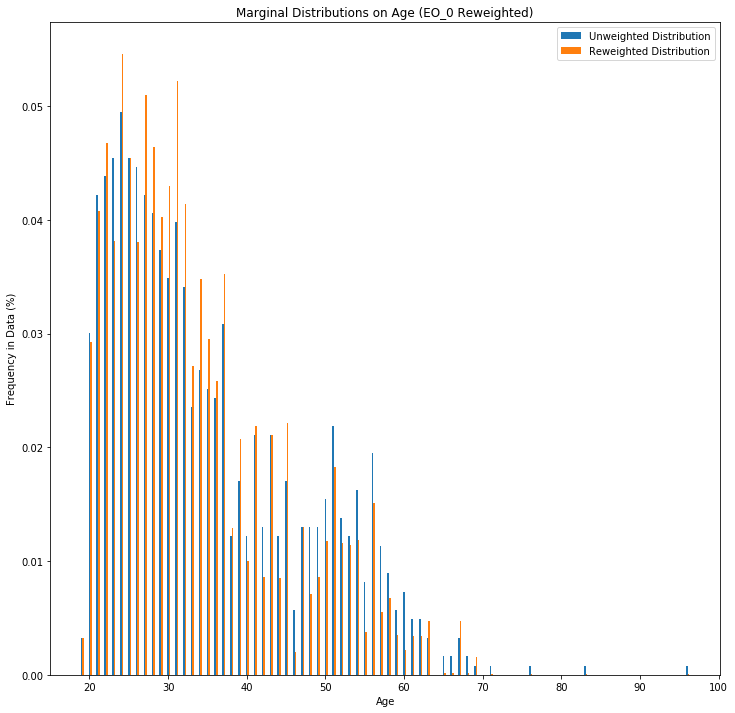

In [26]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age (EO_0 Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [27]:
X_priors_freq = freq_dict(pred_df, 'priors_count')
X_priors_marginal = marginalize(pred_df, 'priors_count', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

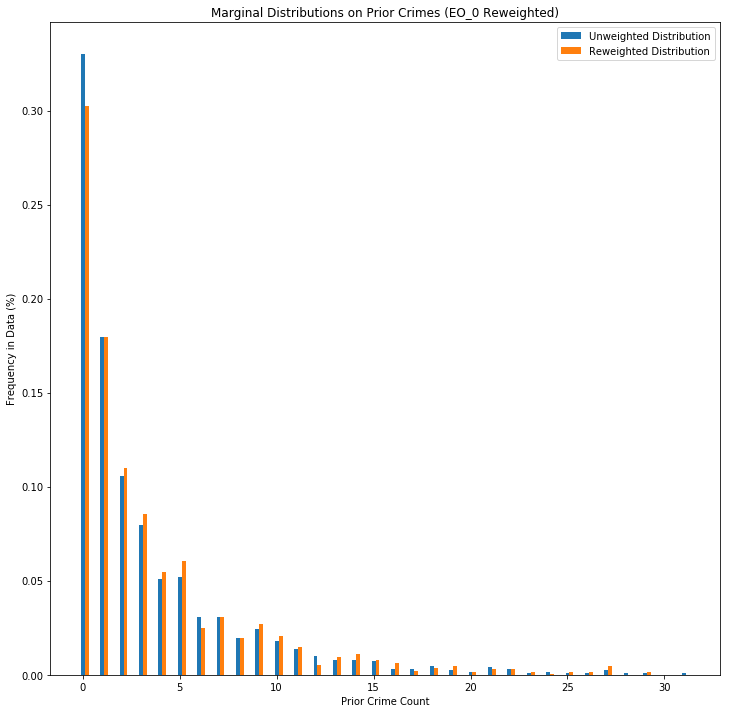

In [28]:
# Marginal Distribution on Prior Crimes 
X = np.asarray(list(X_priors_marginal.keys()))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes (EO_0 Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Prior Crime Count')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [29]:
X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

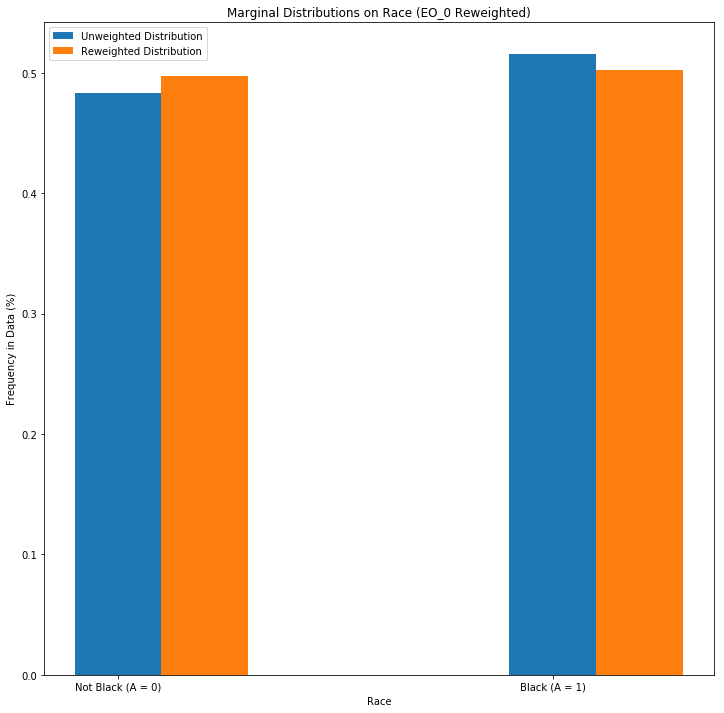

In [30]:
# Marginal Distribution on Race 
X = np.arange(len(X_race_freq))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Race (EO_0 Reweighted)')
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Black (A = 0)', 'Black (A = 1)'])
plt.xlabel('Race')
plt.ylabel('Frequency in Data (%)')
plt.show()

## Experiment with Linear Program (Y = 1)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [31]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y0_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(1, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 0)
  y0_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

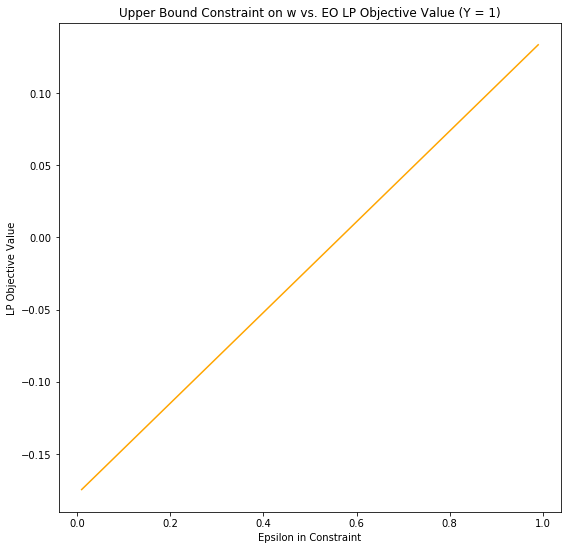

In [32]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y0_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

In [33]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

99
99


## Marginal Distributions (Y = 1)

In [34]:
pred_df['weights'] = epsilon_to_weights[0.9].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction,prediction_prob,weights
0,6128,1,51,1,0,0,0,7,1,0,1,1,0,0.409895,0.001542
1,4571,1,24,1,0,0,0,1,1,0,1,1,1,0.571310,0.001542
2,1426,1,21,0,0,0,0,0,1,1,0,1,0,0.497028,0.001542
3,3209,1,49,0,0,0,0,0,0,0,1,0,0,0.037173,0.000081
4,5771,1,20,1,0,0,0,0,1,1,0,1,1,0.660504,0.001542


In [35]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [36]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

{1: 0.823051948051948, 0: 0.17694805194805194}
{0: 0.17840909174800001, 1: 0.8215909129369922}


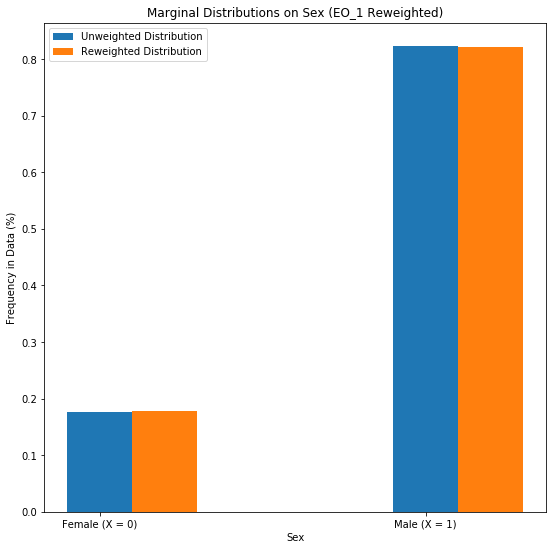

In [37]:
# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(9,9))
plt.title('Marginal Distributions on Sex (EO_1 Reweighted)')
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Female (X = 0)', 'Male (X = 1)'])
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [38]:
X_age_freq = freq_dict(pred_df, 'age')
X_age_marginal = marginalize(pred_df, 'age', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

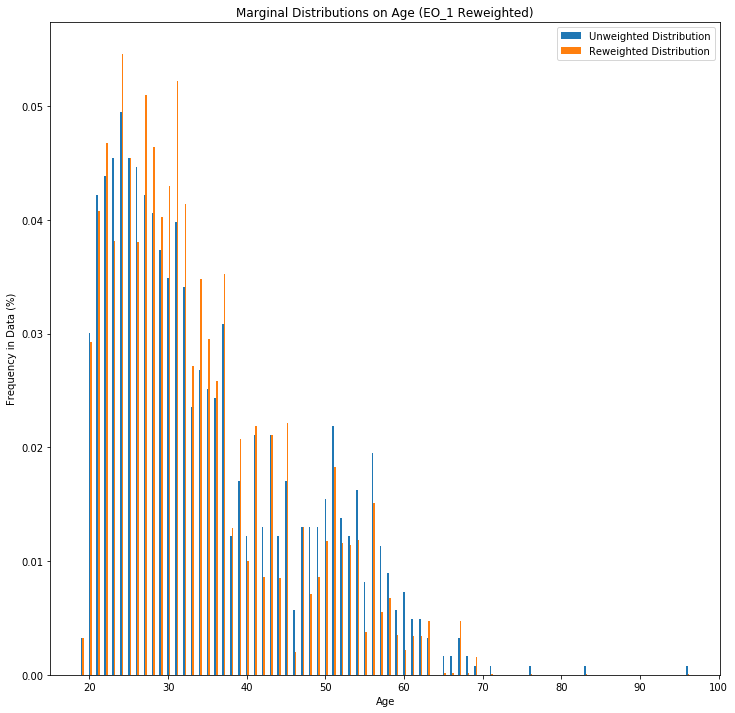

In [39]:
# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Age (EO_1 Reweighted)')
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Age')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [40]:
X_priors_freq = freq_dict(pred_df, 'priors_count')
X_priors_marginal = marginalize(pred_df, 'priors_count', pred_df['weights'])
X_priors_tuple = graph_tuple(X_priors_freq, X_priors_marginal)

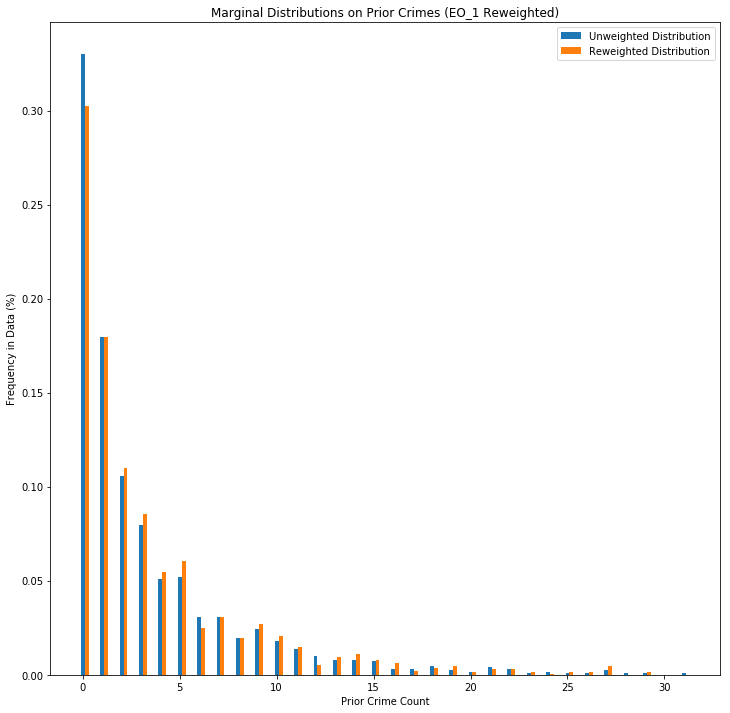

In [41]:
# Marginal Distribution on Prior Crimes 
X = np.asarray(list(X_priors_marginal.keys()))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Prior Crimes (EO_1 Reweighted)')
plt.bar(X, X_priors_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_priors_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xlabel('Prior Crime Count')
plt.ylabel('Frequency in Data (%)')
plt.show()

In [42]:
X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

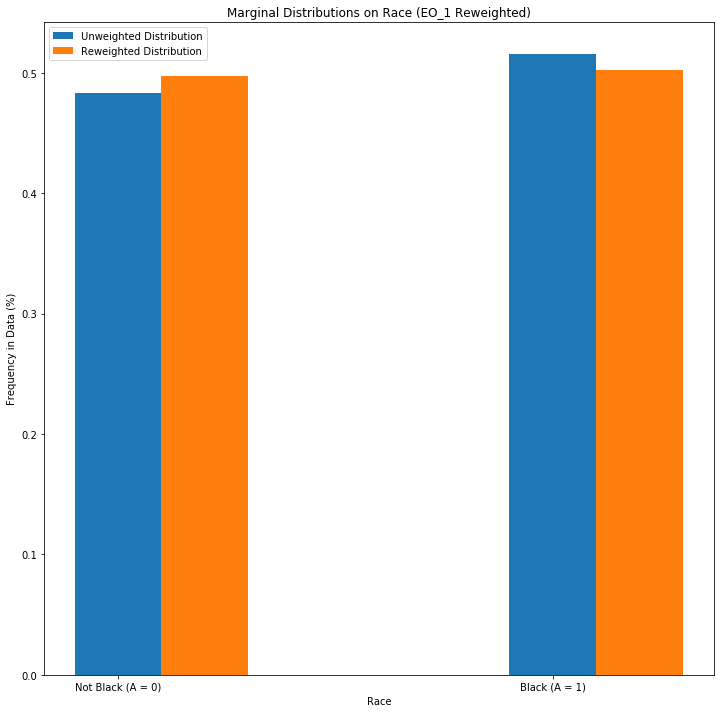

In [43]:
# Marginal Distribution on Race 
X = np.arange(len(X_race_freq))

# Plot the marginal distribution on sex
plt.figure(figsize=(12,12))
plt.title('Marginal Distributions on Race (EO_1 Reweighted)')
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.legend(('Unweighted Distribution','Reweighted Distribution'))
plt.xticks(X, ['Not Black (A = 0)', 'Black (A = 1)'])
plt.xlabel('Race')
plt.ylabel('Frequency in Data (%)')
plt.show()